### Setting up the environment

In [ ]:
%conda install -y -c conda-forge scipy nltk seaborn textblob pytables

In [2]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
import requests
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

import seaborn as sns
nltk.download('wordnet')  
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.downloader.download('vader_lexicon')

%matplotlib inline

#this opinion is used for setting Pandas DataFrame to show non-truncated table
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alcastrica/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alcastrica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/alcastrica/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alcastrica/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Load Data

In [3]:
# ## This cell install the API to get necessary data ##
# %pip install alpaca-trade-api
# from alpaca_trade_api import REST
# rest_client = REST("API_KEY", "SECRET_KEY") # These should be replaced with private API keys
# news = rest_client.get_news(symbol="AAPL", start="2020-06-01", end="2022-06-01", limit=1e6)
# summaries = {new.created_at:new.summary for new in news if new.summary}
# news_series = pd.Series(summaries, name="News Summaries")
# prices = rest_client.get_bars(symbol="AAPL", start="2020-06-01", end="2022-06-01", limit=1e6, timeframe="1Day", adjustment="all").df["vwap"]

# ## Save data to h5 file ##
# news_series.to_hdf("news_sentiment.h5","summaries", "w")
# prices.to_hdf("news_sentiment.h5","prices", "a") # append prices to h5 file

In [4]:
# This cell load the data from the attached .h5 file
news_series = pd.read_hdf("news_sentiment.h5","summaries")
prices = pd.read_hdf("news_sentiment.h5","prices")

In [5]:
# Load contractions json file from the assets folder
with open('../social_data_analytics/sentiment_analysis/assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

### Preprocess data

In [6]:
def remove_emoji(text: str) -> str:
    """Function to remove all emojis from a certain text."""
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' positiveemoji ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', text)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', text)
    return text

In [7]:
def process_text(text: str) -> str:
    """Function to format text in the proper way."""
    text = text.lower()                                             # Lowercases the string
    text = re.sub('@[^\s]+', '', text)                              # Removes usernames
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Remove URLs
    text = re.sub(r"\d+", " ", str(text))                           # Removes all digits
    text = re.sub('&quot;'," ", text)                               # Remove (&quot;) 
    text = remove_emoji(text)                                              # Replaces Emojis
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Removes all single characters
    
    #simple tokenization using split()
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])   # Replaces contractions
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Removes all punctuations
    text = re.sub(r'(.)\1+', r'\1\1', text)    # Convert more than 2 letter repetitions to 2 letter (e.g., cooool)
    text = re.sub(r"\s+", " ", str(text))      # Replaces extra spaces with a single space    
    return text


In [8]:
# resampling to daily frequency
news_series = news_series.resample("d").sum()
# resample returns on news index
prices: pd.Series = prices.resample("d").ffill()
returns = prices.pct_change()

In [9]:
# Process news
processed_news = np.vectorize(process_text)(news_series.astype(str).values)

In [10]:
# Process prices into market sentiment
market_sentiment = returns > 0.0 # all positive returns will be True

In [11]:
news_sentiment = pd.DataFrame(
    {
        "news": news_series.resample("d").sum(), 
        "processed_news": processed_news, 
        "returns": returns,
        "market_sentiment": market_sentiment
    }, index=news_series.index
    ).dropna(axis=0)
news_sentiment = news_sentiment.astype({"market_sentiment": "int"}) # convert True to 1 and False to 0
news_sentiment.head()

,news,processed_news,returns,market_sentiment
2020-06-03 00:00:00+00:00,"Peloton Interactive Inc. (NASDAQ: PTON) has made its fitness app available on Apple Inc.&#39;s (NASDAQ: AAPL) TV devices.Warner Music is set to list at the Nasdaq Stock Market on Wednesday.\n\nWarner Music Could Kickstart A String Of IPOs This Year\n\nThe record label giant is expected to price the initial public offering between $23 to $26 per share, and raise between $11.7 billion and $13.3 billion. \n\nData from Sensor Tower points to Apple Inc. (NASDAQ: AAPL) growing its App Store net revenue by 39% year-over-year in May, and this trend bodes well for the stock, according to Morgan Stanley.Warner Music Group Corp. priced its 77-million-share IPO at $25 per share, and the stock opened higher Wednesday at $27.",peloton interactive inc nasdaq pton has made its fitness app available on apple inc nasdaq aapl tv devices warner music is set to list at the nasdaq stock market on wednesday warner music could kickstart string of ipos this year the record label giant is expected to price the initial public offering between to per share and raise between billion and billion data from sensor tower points to apple inc nasdaq aapl growing its app store net revenue by year over year in may and this trend bodes well for the stock according to morgan stanley warner music group corp priced its million share ipo at per share and the stock opened higher wednesday at,0.002149,1
2020-06-04 00:00:00+00:00,"The shares of Genius Brands International Inc. (NASDAQ: GNUS), a company until recently struggling to keep itself listed on Nasdaq, have added 2458% since May.\n\nThe surge has come following a string of operational advancements and investments announced by the children entertainment company.Of the five component FAANG stocks — Facebook, Inc. (NASDAQ: FB), Amazon.com, Inc (NASDAQ: AMZN), Apple, Inc. (NASDAQ: AAPL),",the shares of genius brands international inc nasdaq gnus company until recently struggling to keep itself listed on nasdaq have added since may the surge has come following string of operational advancements and investments announced by the children entertainment company of the five component faang stocks facebook inc nasdaq fb amazon com inc nasdaq amzn apple inc nasdaq aapl,0.008703,1
2020-06-05 00:00:00+00:00,"Apple Inc. (NASDAQ: AAPL) has weathered the economic impact of the novel coronavirus pandemic in a &#34;Jacques Cousteau-like fashion,&#34; and the consumer electronics company Companies in the United States raised $22.5 billion in the bond market this week, the Financial Times reported on Friday, based on EPFR Global data.FaZe Clan, one of the most prominent gaming organizations, recently celebrated its 10-year anniversary by announcing multiple collaborations and partnerships with different companies.During Friday&#39;s morning session, 115 companies made new 52-week highs.Benzinga&#39;s PreMarket Prep airs every morning from 8-9 a.m. ET. During that fast-paced, highly informative hour, traders and investors tune in to get the major news of the day, the catalysts behind those moves and the corresponding price action for the upcoming session.",apple inc nasdaq aapl has weathered the economic impact of the novel coronavirus pandemic in jacques cousteau like fashion and the consumer electronics company companies in the united states raised billion in the bond market this week the financial times reported on friday based on epfr global data faze clan one of the most prominent gaming organizations recently celebrated its year anniversary by announcing multiple collaborations and partnerships with different companies during friday morning session companies made new week highs benzinga premarket prep airs every morning from et during that fast paced highly informative hour traders and investors tune in to get the major news of the day the catalysts behind those moves and the corresponding price action for the upcoming session,-0.003126,0
2020-06-06 00:00:0

### Sentiment Analysis w/ Vader

In [12]:
vader = SentimentIntensityAnalyzer()
# New words based on financial journalists lingo 
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Update the lexicon
vader.lexicon.update(new_words)
scores = news_sentiment['processed_news'].apply(vader.polarity_scores).tolist()

In [13]:
news_sentiment["score"] = np.array([score["compound"] for score in scores])

In [23]:
news_sentiment[["news", "returns", "market_sentiment", "score"]].head(3) # score is between -1 and 1
# The accuracy looks pretty low.

,news,returns,market_sentiment,score
2020-06-03 00:00:00+00:00,"Peloton Interactive Inc. (NASDAQ: PTON) has made its fitness app available on Apple Inc.&#39;s (NASDAQ: AAPL) TV devices.Warner Music is set to list at the Nasdaq Stock Market on Wednesday.\n\nWarner Music Could Kickstart A String Of IPOs This Year\n\nThe record label giant is expected to price the initial public offering between $23 to $26 per share, and raise between $11.7 billion and $13.3 billion. \n\nData from Sensor Tower points to Apple Inc. (NASDAQ: AAPL) growing its App Store net revenue by 39% year-over-year in May, and this trend bodes well for the stock, according to Morgan Stanley.Warner Music Group Corp. priced its 77-million-share IPO at $25 per share, and the stock opened higher Wednesday at $27.",0.002149,1,0.8591
2020-06-04 00:00:00+00:00,"The shares of Genius Brands International Inc. (NASDAQ: GNUS), a company until recently struggling to keep itself listed on Nasdaq, have added 2458% since May.\n\nThe surge has come following a string of operational advancements and investments announced by the children entertainment company.Of the five component FAANG stocks — Facebook, Inc. (NASDAQ: FB), Amazon.com, Inc (NASDAQ: AMZN), Apple, Inc. (NASDAQ: AAPL),",0.008703,1,0.4404
2020-06-05 00:00:00+00:00,"Apple Inc. (NASDAQ: AAPL) has weathered the economic impact of the novel coronavirus pandemic in a &#34;Jacques Cousteau-like fashion,&#34; and the consumer electronics company Companies in the United States raised $22.5 billion in the bond market this week, the Financial Times reported on Friday, based on EPFR Global data.FaZe Clan, one of the most prominent gaming organizations, recently celebrated its 10-year anniversary by announcing multiple collaborations and partnerships with different companies.During Friday&#39;s morning session, 115 companies made new 52-week highs.Benzinga&#39;s PreMarket Prep airs every morning from 8-9 a.m. ET. During that fast-paced, highly informative hour, traders and investors tune in to get the major news of the day, the catalysts behind those moves and the corresponding price action for the upcoming session.",-0.003126,0,0.9168


### Sentiment Analysis with Vectorization and Naive Bayes Classification

In [15]:
# Vectorization
count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram (single words) and Bigram (two consecutive words)
final_vectorized_data = count_vectorizer.fit_transform(news_sentiment['processed_news'])  

print(final_vectorized_data.toarray())

print(type(final_vectorized_data))

[[2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [2 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [5 0 0 ... 0 0 0]]
<class 'scipy.sparse._csr.csr_matrix'>


In [16]:
# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, news_sentiment["market_sentiment"],
                                                    test_size=0.2, random_state=69)  

In [17]:
# Naive Bayes Classifier
model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

### Prediction Accuracy Analysis

In [18]:
score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes:", score_naive)

Accuracy with Naive-bayes: 0.6027397260273972


In [19]:
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73        94
           1       0.38      0.17      0.24        52

    accuracy                           0.60       146
   macro avg       0.51      0.51      0.48       146
weighted avg       0.55      0.60      0.56       146



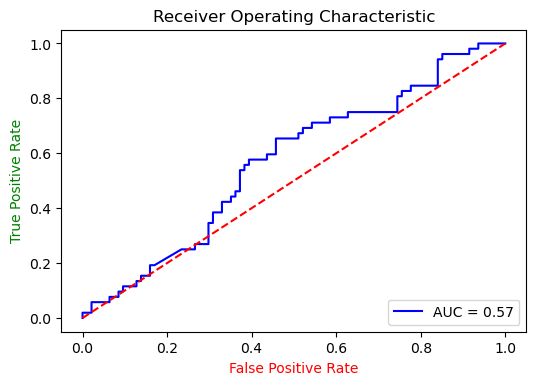

In [20]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=100)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()